#UV treated Silk pattern decomposition
#Instead of using full 9 peaks, this script will instead use "Quantitative approach to study secondary structure of proteins by FT-IR spectroscopy, using a model wheat gluten system
Author links open overlay panelMehtapFevziogluabOguz KaanOzturkbcBruce R.HamakerbcOsvaldo H.Campanellabd" and only analyze 4 "peaks"
 beta-sheet (low frequency)
 random structure & alpha helix
 beta-turn
 Beta sheet (high frequency)

This notebook is bsed on a previously developed tool demonstrating how to perform spectral deconvolution using the FTIR tool suite developed by KBI Biopharma. 

The spectral deconvolution tools utilize the scipy solvers to deconvolute second derivative or fourier self deconvolution spectra using a guassian peak model. There are three parameters per peak (mean, height and width), and thus 36 inputs are present for a 12 peak reference set. The default peak definitions `yang_h20_2015` has 14 peaks, and thus 42 input parameters are present. The parameter space is very large, and thus different gradient based solvers are likely to converge to slightly different local minima. A least squares approach using a linear loss function `rho(z) = z` was used for decomposition

Modified by Jeff
6.2.22: Need to apply FSD to spectra as I don't think this is being applied here before the least-squares fitting method




Setup, Import Code

In [1]:
# imports
%matplotlib inline
import os
import pandas as pd
import numpy as np #import to take 2nd derivative as I don't think this occured, Jeff 2.28.2022 
import sys
#maybe need to do this in case I change the path at the end for saving elsewhere?
os.chdir(r'C:\Users\jrosh\Documents\FTIR_Mapping\ftir')
sys.path.append("../")
import ftir.modeling.peak_fitting as peak_fitting
from ftir.modeling.buffer_subtraction import find_buffer_subtraction_constant, buffer_subtract
from ftir.modeling.peak_fitting import gaussian_minimize, gaussian_differential_evolution, gaussian_least_squares
from ftir.modeling.peak_fitting import secondary_structure, create_fit_plots, gaussian_list, sd_baseline_correction
from ftir.modeling.peak_fitting import create_fit_singleplot #added this to avoid additional layer of subplotting of residuals
# from ftir.modeling.peak_definitions import yang_h20_2015, dong_h2o_1990, yang_list
from ftir.io.utils import create_df_from_single_file
import ftir.modeling.peak_definitions 
from ftir.modeling.peak_definitions import four_peak

import math
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.spatial import ConvexHull

import time
import tkinter as tk
from tkinter import *
from tkinter import filedialog

import seaborn as sns

In [2]:
from ftir.modeling.peak_definitions import four_peak
print(four_peak)

four_peak = {
    'means': [1627,  1650, 1679,1700],
    'uncertainties': [(1616, 1637), (1638, 1662), (1663, 1696), (1697, 1703)],
    #'relative_uncertainties': [10, 12, 16,3],
    'relative_uncertainties': [2, 2, 1,2],
    'assignments': ['aggregate \u03B2-strand/\u03B2-sheet',
                    'random coils + \u03B1 helices', '\u03B2-turns', 'intermolecular \u03B2-sheets (weak)']
}

print(four_peak)

{'means': [1627, 1650, 1679, 1700], 'uncertainties': [(1616, 1637), (1638, 1662), (1663, 1696), (1697, 1703)], 'relative_uncertainties': [2, 2, 2, 2], 'assignments': ['aggregate β-strand/β-sheet', 'random coils + α helices', 'β-turns', 'intermolecular β-sheets (weak)']}
{'means': [1627, 1650, 1679, 1700], 'uncertainties': [(1616, 1637), (1638, 1662), (1663, 1696), (1697, 1703)], 'relative_uncertainties': [2, 2, 1, 2], 'assignments': ['aggregate β-strand/β-sheet', 'random coils + α helices', 'β-turns', 'intermolecular β-sheets (weak)']}


In [15]:
# import data file in csv format (modify for your file path/file name between the "" if you want to, leave blank for GUI option)
# Takes a csv file with first column being wavenumbers, 2nd and onward are relative intensity values, no heads

# #Manual Filename Entry, commented out and instead using GUI for now
# filenamevar = r"R:\Jeff\FTIR\Structural Mapping\7.21.2022 22.5wt%120mb\InvenioATR1hr60C0hr3hr6hrUVtestCombinedNoLabel.csv"

filenamevar = r""
#rawData_df ="nil"
if bool(filenamevar):
    rawData_df = pd.read_csv(filenamevar, header=None)
else:
    print('entering GUI file input mode via Tkinter')
    win = Tk()
    win.wm_attributes('-topmost', 1)
    
    win.withdraw() # prevents an empty tkinter window from appearing
    #top = Toplevel()
    def func():
        global filenamevar
        filenamevar = filedialog.askopenfilename(multiple = True,filetypes =[ ('DPT,CSV, or typeless OPUS files','*.dpt *.csv .*'),('CSV Files', '*.csv'),('Typeless files from OPUS','.*')],
        parent=win,  title='Open a CSV file of Wavenumber (first column) and data points in subsequent columnns to analyze',
        initialdir='R:\Jeff\FTIR\Structural Mapping\7.21.2022 22.5wt%120mb\CalibrationOf45cWAing')  #, header=1,)
        global rawData_df
        print(filenamevar)
        print(type(filenamevar))
        print(len(filenamevar))
        if len(filenamevar)>1:
            print("multiple files, tuple")
            spectral_data = {}
            for file in filenamevar:
                spectral_data[os.path.basename(file)] = pd.read_csv(file,sep = "\t", header=None,names = (["wavenumber", os.path.basename(file)]))
            rawData_df = pd.DataFrame()
            for key, values in spectral_data.items():
                rawData_df['wavenumber'] = values['wavenumber']
                rawData_df[key] = values[key]
            wnrawData_df = rawData_df #already has wavenumber in the first column header
        elif filenamevar[0].endswith('.csv'):
            print('single csv')
            rawData_df = pd.read_csv(filenamevar[0], header=None) # put something about wavenumber here?
            #put wavenumber in the first column header
            dims = []
            for i in range(1,rawData_df.shape[1]):
                dims.append(f"cols{i}")
            column_names = list(['wavenumber'])+ dims
            wnrawData_df = pd.DataFrame(rawData_df.values, columns = column_names)
        elif filenamevar[0].endswith('.dpt'):
            print('single dpt')
            rawData_df = pd.read_csv(filenamevar[0], header=None, sep = "\t") #,names = (["wavenumber",[1,]]))
            #put wavenumber in the first column header
            dims = []
            for i in range(1,rawData_df.shape[1]):
                dims.append(f"cols{i}")
            column_names = list(['wavenumber'])+ dims
            wnrawData_df = pd.DataFrame(rawData_df.values, columns = column_names)
        #to do: add something here for single xy file output from OPUS:
        # else:
        #     rawData_df = pd.read_csv(filenamevar, header=None, sep = "\t") #,names = (["wavenumber",[1,]]))
        #     rawData_df
        win.wm_attributes('-topmost', False)
        win.destroy()

    def quit():
        win.destroy() 

    func()
    # quit()

    win.mainloop()

entering GUI file input mode via Tkinter
('R:/Jeff/FTIR/Structural Mapping/7.21.2022 22.5wt%120mb/CalibrationOf45cWAing/xy/xyMinutes/0min.3', 'R:/Jeff/FTIR/Structural Mapping/7.21.2022 22.5wt%120mb/CalibrationOf45cWAing/xy/xyMinutes/0min.4', 'R:/Jeff/FTIR/Structural Mapping/7.21.2022 22.5wt%120mb/CalibrationOf45cWAing/xy/xyMinutes/5min.0', 'R:/Jeff/FTIR/Structural Mapping/7.21.2022 22.5wt%120mb/CalibrationOf45cWAing/xy/xyMinutes/5min.1')
<class 'tuple'>
4
multiple files, tuple


In [17]:
# filenamevar[0]
#rawData_df
#wnrawData_df

,wavenumber,0min.3,0min.4,5min.0,5min.1
0,3998.51641,0.00257,0.00320,0.00312,0.00360
1,3997.08837,0.00250,0.00318,0.00312,0.00354
2,3995.66033,0.00249,0.00315,0.00313,0.00350
3,3994.23229,0.00253,0.00315,0.00317,0.00351
4,3992.80425,0.00263,0.00319,0.00323,0.00358
...,...,...,...,...,...
2516,405.56381,0.31728,0.33495,0.33427,0.36724
2517,404.13577,0.31652,0.33371,0.33339,0.36630
2518,402.70772,0.31563,0.33271,0.33220,0.36505
2519,401.27968,0.31438,0.33207,0.33086,0.36378


In [38]:
# Jeff 6.14.2022 
# Make a simple input for x and y dimensions of mapping
# Modified from https://www.geeksforgeeks.org/python-tkinter-entry-widget/
# Returns xvalue and yvalue globally
root=tk.Tk()
 
# setting the windows size
root.geometry("450x100")
root.eval('tk::PlaceWindow . center')
#root.lift()

# declaring numerical variables for storing x and y values
x_var=tk.IntVar()
y_var=tk.IntVar()
   
# defining a function that will get x and y values and close the window
def submit():
    global user_message_entry, num_in_x,num_in_y
    # t = Toplevel(root)
    num_in_x=int(x_var.get())
    num_in_y=int(y_var.get())
    print("Total number of spectra: " + str(num_in_x*num_in_y))
    time.sleep(0.5)
    root.destroy()
    
# creating a label for x using widget Label
x_label = tk.Label(root, text = 'Number of mapping points in x : ', font=('calibre',10, 'bold'))
  
# creating a entry for input of x using widget Entry
x_entry = tk.Entry(root,textvariable = x_var, font=('calibre',10,'normal'))
  
# creating a label for y using widget Label
y_label = tk.Label(root, text = 'Number of mapping points in y : ', font = ('calibre',10,'bold'))
  
# creating a entry for y using widget Entry
y_entry=tk.Entry(root, textvariable = y_var, font = ('calibre',10,'normal'))
  
# creating a button using the widget button that will call the submit function
sub_btn=tk.Button(root,text = 'Submit', command=lambda: submit())
  
# placing the label and entry in the required position using grid method
x_label.grid(row=0,column=0)
x_entry.grid(row=0,column=1)
y_label.grid(row=1,column=0)
y_entry.grid(row=1,column=1)
sub_btn.grid(row=2,column=1)

# performing an infinite loop for the window to display
root.mainloop()

Total number of spectra: 18


In [39]:
# GUI to prompt user for directory to save spectra, 1-d data, heatmap, and csv of data with statistical analysis 
import tkinter as tk
from tkinter import *
from tkinter import filedialog

savefolderpath = r""
#rawData_df ="nil"
if bool(savefolderpath):
    rawData_df = pd.read_csv(savefolderpath, header=None)
else:
    print('entering GUI file input mode via Tkinter')
    win = Tk()
    win.wm_attributes('-topmost', 1)
    
    win.withdraw() # prevents an empty tkinter window from appearing
    #top = Toplevel()
    def func():
        global savefolderpath
        savefolderpath = filedialog.askdirectory(parent=win, title='Select a folder wherein your results will be saved',
        initialdir=os.path.dirname(os.path.dirname(filenamevar[0]))) #, header=1,)
        # global rawData_df
        # rawData_df = pd.read_csv(filenamevar, header=None)
        print(savefolderpath)
        win.wm_attributes('-topmost', False)
        win.destroy()

    def quit():
        win.destroy() 

    func()
    win.mainloop()

entering GUI file input mode via Tkinter
C:/Users/jrosh/Desktop/jeffsFFscript9x2


In [6]:
#rawData_df.head(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,3998.51641,-0.09361,-0.08154,-0.07808,-0.09209,-0.07684,-0.07520,-0.09511,-0.07784,-0.07202,-0.07581,-0.09211,-0.07917,-0.09340,-0.09399,-0.07589,-0.07747,-0.09490,-0.07616
1,3997.08837,-0.09359,-0.08153,-0.07806,-0.09208,-0.07681,-0.07518,-0.09508,-0.07779,-0.07198,-0.07577,-0.09208,-0.07915,-0.09336,-0.09397,-0.07589,-0.07745,-0.09485,-0.07610
2,3995.66033,-0.09362,-0.08158,-0.07810,-0.09207,-0.07684,-0.07518,-0.09508,-0.07781,-0.07200,-0.07577,-0.09209,-0.07915,-0.09338,-0.09399,-0.07594,-0.07747,-0.09485,-0.07608
3,3994.23229,-0.09367,-0.08165,-0.07816,-0.09206,-0.07687,-0.07515,-0.09509,-0.07783,-0.07201,-0.07576,-0.09210,-0.07917,-0.09339,-0.09401,-0.07598,-0.07747,-0.09485,-0.07608


In [9]:
#moved to import 8/24 - BAD IDEA?
#  dims = []
# for i in range(1,rawData_df.shape[1]):
#     dims.append(f"cols{i}")

# column_names = list(['wavenumber'])+ dims
# #type(column_names[3])
# #column_names

# # changed this from beta_sheet_df since it contains everything? 
# wnrawData_df = pd.DataFrame(rawData_df.values, columns = column_names)
# wnrawData_df

# #maybe don't even need this? or maybe that's only if it's a multi-file import and it's done in the first GUI

,wavenumber,cols1,cols2,cols3,cols4,cols5,cols6,cols7,cols8,cols9,cols10,cols11,cols12,cols13,cols14,cols15,cols16,cols17,cols18
0,3998.51641,-0.09361,-0.08154,-0.07808,-0.09209,-0.07684,-0.07520,-0.09511,-0.07784,-0.07202,-0.07581,-0.09211,-0.07917,-0.09340,-0.09399,-0.07589,-0.07747,-0.09490,-0.07616
1,3997.08837,-0.09359,-0.08153,-0.07806,-0.09208,-0.07681,-0.07518,-0.09508,-0.07779,-0.07198,-0.07577,-0.09208,-0.07915,-0.09336,-0.09397,-0.07589,-0.07745,-0.09485,-0.07610
2,3995.66033,-0.09362,-0.08158,-0.07810,-0.09207,-0.07684,-0.07518,-0.09508,-0.07781,-0.07200,-0.07577,-0.09209,-0.07915,-0.09338,-0.09399,-0.07594,-0.07747,-0.09485,-0.07608
3,3994.23229,-0.09367,-0.08165,-0.07816,-0.09206,-0.07687,-0.07515,-0.09509,-0.07783,-0.07201,-0.07576,-0.09210,-0.07917,-0.09339,-0.09401,-0.07598,-0.07747,-0.09485,-0.07608
4,3992.80425,-0.09366,-0.08169,-0.07815,-0.09202,-0.07684,-0.07508,-0.09506,-0.07782,-0.07196,-0.07571,-0.09205,-0.07914,-0.09336,-0.09397,-0.07594,-0.07742,-0.09480,-0.07605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,605.48963,0.13839,0.14484,0.14891,0.15892,0.15442,0.15648,0.15466,0.15307,0.16291,0.14932,0.14828,0.14752,0.15661,0.15527,0.15354,0.16148,0.15354,0.16162
2377,604.06159,0.13876,0.14538,0.14964,0.16086,0.15560,0.15916,0.15497,0.15322,0.16464,0.14989,0.14952,0.14794,0.15864,0.15680,0.15585,0.16225,0.15354,0.16273
2378,602.63355,0.13904,0.14606,0.15047,0.16347,0.15695,0.16127,0.15548,0.15358,0.16664,0.15112,0.15046,0.14867,0.16082,0.15854,0.15820,0.16298,0.15392,0.16370
2379,601.20550,0.13899,0.14668,0.15128,0.16635,0.15834,0.16223,0.15601,0.15427,0.16899,0.15278,0.15096,0.14965,0.16295,0.16055,0.16005,0.16373,0.15486,0.16468


## Baseline correction

Rubberband baseline correction, flipping the spectra over the y-axis, and narrowing focus only on the amide I region.(Do we need to normalize to 1?)

In [51]:
#only show between 1715 and 1595
blcorrectedAmideI = []
# for cols_ in beta_sheet_df.columns[1:]:
#     #print(str(cols_))
#     blcorrectedAmideI.append(sd_baseline_correction(beta_sheet_df, cols=[cols_], flip=False, method='rubberband', bounds=(1715, 1595)))
for cols_ in wnrawData_df.columns[1:]:
    #print(str(cols_))
    blcorrectedAmideI.append(sd_baseline_correction(wnrawData_df, cols=[cols_], flip=False, method='rubberband', bounds=(1715, 1595)))

print(rawData_df.columns)

#newDF

#print(column_headers)

TypeError: '>' not supported between instances of 'str' and 'int'

In [ ]:
#blcorrectedAmideI
#beta_sheet_df

[    wavenumber     cols1
 0   1713.64989  0.000000
 1   1712.22185  0.000832
 2   1710.79381  0.001873
 3   1709.36577  0.003135
 4   1707.93772  0.004936
 ..         ...       ...
 79  1600.83461  0.018154
 80  1599.40657  0.013005
 81  1597.97852  0.008567
 82  1596.55048  0.004318
 83  1595.12244  0.000000
 
 [84 rows x 2 columns],
     wavenumber     cols2
 0   1713.64989  0.000000
 1   1712.22185  0.000975
 2   1710.79381  0.002119
 3   1709.36577  0.003464
 4   1707.93772  0.005368
 ..         ...       ...
 79  1600.83461  0.020912
 80  1599.40657  0.014956
 81  1597.97852  0.009821
 82  1596.55048  0.004925
 83  1595.12244  0.000000
 
 [84 rows x 2 columns],
     wavenumber     cols3
 0   1713.64989  0.000000
 1   1712.22185  0.000877
 2   1710.79381  0.001994
 3   1709.36577  0.003351
 4   1707.93772  0.005278
 ..         ...       ...
 79  1600.83461  0.020072
 80  1599.40657  0.014349
 81  1597.97852  0.009446
 82  1596.55048  0.004753
 83  1595.12244  0.000000
 
 [84 rows 

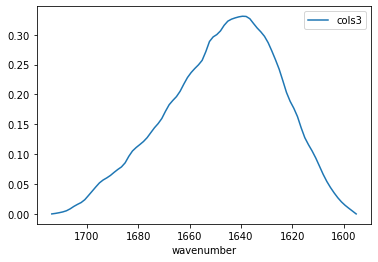

In [ ]:
blcorrectedAmideI[2].plot.line(x='wavenumber', y=blcorrectedAmideI[2].columns[1]).invert_xaxis()

In [ ]:
#this is in peak_fitting but I'm putting it here so peak libraries and other paramters like gain can be changed

reluncert = 5
gainnum = 0.90 #gain, was originally 0.95

def gaussian_least_squares_(df, col, peaks, peak_width, params=dict()): 
# peak width taken from: 
# "Quantitative approach to study secondary structure of proteins by FT-IR spectroscopy, using a model wheat gluten system"

    def fun(p, x, y):
        """ Minimizing across parameter space p, for a given range, x"""
        return gaussian_sum(x, *p) - y

    data = np.array(pd.concat([df.iloc[:,0], df[col]], axis=1))
    heights = guess_heights_(df, col, peaks['means'], gain=gainnum)
    width = peak_width
    lb = list()
    ub = list()
    guess = list()

    # Make 1-D array for optimization func definition above
    for mean, bound, height in zip(peaks['means'], peaks['uncertainties'],
                                   heights):
        lb.extend([0, bound[0], 0])
        ubh = np.inf if height <= 0 else height
        ub.extend([ubh, bound[1], peak_width*1])
        guess.extend([height*0.95, mean, peak_width])

    args = [fun, np.array(guess)]
    params['args'] = (data[:, 0], data[:, 1])
    params['bounds'] = (np.array(lb), np.array(ub))
    res = optimize.least_squares(*args, **params)

    areas = list()
    for i in range(0, len(res.x), 3):
        height = res.x[i]
        width = res.x[i+2]
        area = gaussian_integral(height, width)
        areas.append(area)
    return areas, res

def guess_heights_(df, col, center_list, gain=0.90):
    """ Determines guesses for the heights based on measured data.

    Function creates an integer mapping to the measured frequencies, and then
    creates an initial peak height guess of gain*actual height at x=freq*. A
    Default of 0.95 seems to work best for most spectra, but can be change to
    improve convergence.

    Parameters
    ----------
    df : Dataframe
        Dataframe containing the measured absorbance data

    col : string or integer
        Column index for the absorbance data being fit. Accepts either index
        or string convention.

    center_list : iterable of integers
        An iterable of integer peak positions used to find the experiment
        absorbance at a given wavenumber. I.e, the heights are returned at the
        center values in this iterable

    gain : number (optional)
        Fraction of the measured absorbance value to use determine the initial
        guess for the peak height. The value Default value is 0.95, and thus
        by default, all initial peak guesses are 95% of the peak max.

    """
    heights = []
    freq_map = {}
    for i in df.iloc[:,0]:
        j = math.floor(i)
        freq_map[j] = float(df[col].get(df.iloc[:,0] == i))
    print(freq_map)
    # pdb.set_trace()
    for i in center_list:
        height = freq_map[i]
        heights.append(gain*height)
    return heights

######Plotting spectra and their invidual fits

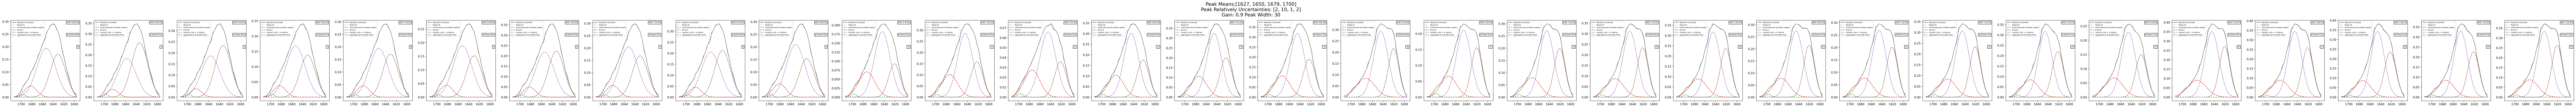

In [ ]:
# Jeff 6/10/2022: attempt to use non-flattened indices so that I can more easily think about the math for propper placement of "pixels"; from above, the plots start at top left, but
# should actually start at bottom left. Need to confirm if the grid is started from another corner whether the FT-IR starts measuring from another corner, and then possibly put another gui to allow 
# users to select which corner data collection starts in
pw = 30 #peak width 30cm^-1 from "Quantitative approach to study secondary structure of proteins by FT-IR spectroscopy, using a model wheat gluten system"
peakfitlibname = 'four_peak'
peaksfittinglib = four_peak 

from matplotlib.offsetbox import AnchoredText

fig, axs = plt.subplots(num_in_y,num_in_x, figsize=(num_in_x*5,num_in_y*5),dpi=200)
titletext  = ('Peak Means:' + str(peaksfittinglib['means']) +"\n" + 'Peak Relatively Uncertainties: ' + str(peaksfittinglib['relative_uncertainties']) + 
    "\n" + 'Gain: ' + str(gainnum) + ' Peak Width: ' + str(pw))
fig.suptitle(titletext, fontsize=16,y=1.05, va='top')
fig.subplots_adjust(hspace=.2, wspace=.2)

structs =[]
gaussian_data = []

for j in range(0,num_in_y):
    for i in range(0,num_in_x):     

        indexnum=(num_in_x)*(num_in_y-(j+1))+i #this should convert current index to the correct index from the original "linear" dataset since the data point table doesn't have any location information
        # need to confirm that if data collection starts in another corner other than lower left (upper right, lower right, etc.), that this doesn't require a different re-indexing operation
      
        sample = blcorrectedAmideI[(num_in_x)*(num_in_y-1-j)+i].columns[1]
        area, res = gaussian_least_squares(blcorrectedAmideI[(num_in_x)*(num_in_y-(j+1))+i], 
                                        blcorrectedAmideI[(num_in_x)*(num_in_y-(j+1))+i].columns[1], peak_width=pw, 
                                        peaks=peaksfittinglib, params={'loss':'linear'}) 
        structs.append(secondary_structure(area, peaksfittinglib)) #secondary_structure() returns dict
        gaussian_list_data = gaussian_list(blcorrectedAmideI[(num_in_x)*(num_in_y-(j+1))+i]['wavenumber'], *res.x)
        gaussian_data.append(gaussian_list_data)
        
        #does this math work for crawling through the numbers? maybe this is where I need to apply the logic and put the right data in the right place?
        xdata = blcorrectedAmideI[(num_in_x)*(num_in_y-(j+1))+i].iloc[:,0]
        y_fit = sum(gaussian_list_data)
        #probably should have just done this normally and then transposed/flipped the data frame. Maybe next time 

        # index is a bit whack here, need to start from bottom left and starts from top left 
        #      
        # need to modify for running a series of data not from mapping, or running a line (in which case one of the two dimensions are ==1)
        if (num_in_y == 1) or (num_in_x == 1):
            axs[i].plot(xdata, blcorrectedAmideI[i][sample],label='Baseline Corrected') #Jeff changed this to 'Baseline Corrected' from '$2^{nd}$ derivative' on 3.23.2022
            axs[i].plot(xdata, y_fit, label='Model fit',ls='-.',linewidth=1) 
            # calculate RSS for each spectrum
            resid = blcorrectedAmideI[(num_in_x)*(num_in_y-(j+1))+i][sample] - y_fit
            # sum of square residuals - want to minimize this, might need to run some algorithm to do this
            rss = sum(resid*resid)

            # Jeff 5.31.22: Label each of the gaussian curves with the correct type of peak
            for k in range(len(gaussian_list_data)):
                axs[i].plot(xdata, gaussian_list_data[len(peaksfittinglib['means'])-1-k], ls='--', 
                label=str(peaksfittinglib['assignments'][len(peaksfittinglib['means'])-1-k])) #label=str(structs[j][1])) #label='')
            axs[i].invert_xaxis()
            
            legend1 = axs[i].legend(loc="upper left",fontsize='xx-small')
            rssTitle = "RSS: "+ str("{:.1e}".format(rss))
            rssText = AnchoredText(rssTitle, loc='upper right', prop=dict(size=6), frameon=True)           
            ratioText = '\u03B2-Sheet:'+ str("{:.0%}".format(structs[num_in_x*j+i]['aggregate \u03B2-strand/\u03B2-sheet'] +
                structs[num_in_x*j+i]['intermolecular \u03B2-sheets (weak)']))
            axs[i].add_artist(rssText)
            aRatioText = AnchoredText(ratioText, loc='upper right', prop=dict(size=6), frameon=True, bbox_to_anchor=(1., 0.85),
                            bbox_transform=axs[i].transAxes)
            axs[i].add_artist(aRatioText)
            strindexnum= str(indexnum)
            numberinlist = AnchoredText(strindexnum, loc='upper right', prop=dict(size=6), frameon=True,bbox_to_anchor=(1., 0.7),bbox_transform=axs[i].transAxes)
            axs[i].add_artist(numberinlist)        
        else:
            axs[j,i].plot(xdata, blcorrectedAmideI[(num_in_x)*(num_in_y-(j+1))+i][sample],label='Baseline Corrected') #Jeff changed this to 'Baseline Corrected' from '$2^{nd}$ derivative' on 3.23.2022
            axs[j,i].plot(xdata, y_fit, label='Model fit',ls='-.',linewidth=1) 
            # calculate RSS for each spectrum
            resid = blcorrectedAmideI[(num_in_x)*(num_in_y-(j+1))+i][sample] - y_fit
            # sum of square residuals - want to minimize this, might need to run some algorithm to do this
            rss = sum(resid*resid)

            # Jeff 5.31.22: Label each of the gaussian curves with the correct type of peak
            for k in range(len(gaussian_list_data)):
                axs[j,i].plot(xdata, gaussian_list_data[len(peaksfittinglib['means'])-1-k], ls='--', 
                label=str(peaksfittinglib['assignments'][len(peaksfittinglib['means'])-1-k])) #label=str(structs[j][1])) #label='')
            axs[j,i].invert_xaxis()
            
            legend1 = axs[j,i].legend(loc="upper left",fontsize='xx-small')
            rssTitle = "RSS: "+ str("{:.1e}".format(rss))
            rssText = AnchoredText(rssTitle, loc='upper right', prop=dict(size=6), frameon=True)           
            ratioText = '\u03B2-Sheet:'+ str("{:.0%}".format(structs[num_in_x*j+i]['aggregate \u03B2-strand/\u03B2-sheet'] +
                structs[num_in_x*j+i]['intermolecular \u03B2-sheets (weak)']))
            axs[j,i].add_artist(rssText)
            aRatioText = AnchoredText(ratioText, loc='upper right', prop=dict(size=6), frameon=True, bbox_to_anchor=(1., 0.85),
                            bbox_transform=axs[j,i].transAxes)
            axs[j,i].add_artist(aRatioText)
            strindexnum= str(indexnum)
            numberinlist = AnchoredText(strindexnum, loc='upper right', prop=dict(size=6), frameon=True,bbox_to_anchor=(1., 0.7),bbox_transform=axs[j,i].transAxes)
            axs[j,i].add_artist(numberinlist)

fullfigname = (savefolderpath+'/'+'spectra.png')
plt.savefig(fullfigname)
plt.show()

Compare % of beta sheet via Seaborn Heatmap

[0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 10, 10, 10, 10, 10, 10, 30, 30, 30, 30, 30, 60, 60, 60, 60, 60, 120, 120, 120, 120, 120]


<AxesSubplot:>

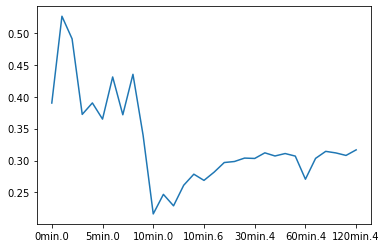

In [ ]:
total_beta_percent = []
for i in range(0, len(structs)):
    total_beta_percent.append(
        structs[i]['aggregate \u03B2-strand/\u03B2-sheet'] + structs[i]['intermolecular \u03B2-sheets (weak)'])
#print('type of total_beta_percent:',type(total_beta_percent))
# also make a new dataframe for math later
#total_beta_percent_df = pd.DataFrame(columns = total_beta_percent)

#print('total beta %', total_beta_percent)

# make two DFs, one with all secondary structure values, and then another one with total beta sheet only

secondary_structs_df = pd.DataFrame.from_dict(
    structs, orient='columns')  # columns=rawData_df[2:].columns)
secondary_structs_df = secondary_structs_df.transpose()
secondary_structs_df.columns = rawData_df.columns[1:]
# print(secondary_structs_df)

# for j in range(0,len(structs)):
#     structs_df[j] = pd.DataFrame(list(structs[j].items()), columns=['Structure','Fraction'])
# #structs_df.to_csv('/home/jovyan/ftir_data_analytics/data/fitted_results/'+sample+'.csv', index=False)
# print(structs_df)

total_beta_sheet_df = pd.DataFrame(total_beta_percent, columns = ['TotalBetaSheet%'])
total_beta_sheet_df.index = rawData_df.columns[1:]
#rawData_df.columns[0] = rawData_df.columns['fileheader','total beta_sheet %']

extractedtime = []
extractedsamplenumber = []
for i in range(len(rawData_df.columns[1:])):
    splitname = rawData_df.columns[1:][i].split("min")
    extractedtime.append(int(splitname[0]))
    splitname2 = rawData_df.columns[1:][i].split(".")
    extractedsamplenumber.append(splitname2[1])
print(extractedtime)

total_beta_sheet_df['Minutes'] = extractedtime
total_beta_sheet_df['SampleNumber'] = extractedsamplenumber
total_beta_sheet_df = total_beta_sheet_df[['Minutes','SampleNumber','TotalBetaSheet%']]
#print(total_beta_sheet_df)
# #print(total_beta_sheet_df['1hr.0'])
# #print(total_beta_sheet_df['1hr.0']+total_beta_sheet_df['1hr.1'])

# #Split up points into x by y grid
# break_total_beta_percent = np.array_split(np.array(total_beta_percent),num_in_y)
# #print(break_total_beta_percent)

#total_beta_sheet_df[total_beta_sheet_df['Minutes']==5]['TotalBetaSheet%']
total_beta_sheet_df['TotalBetaSheet%'].plot()



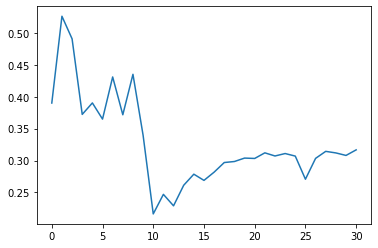

In [ ]:
# 2D plot just in case it's useful
plt.plot(total_beta_percent)
fullfigname = (savefolderpath+'/'+'1-D.png')
plt.savefig(fullfigname)


In [ ]:
#heatmap via seaborn, plotted from 0 to 50% beta sheet content:
plt.figure(figsize = (num_in_x,num_in_y),dpi=200)

#save beta sheet content into csv; if from single microscopy file, use the shape of the data as it is; if it's from multiple files, save it with the header
fullcsvname = (savefolderpath+'/'+'peakdata.csv')
np.savetxt(fullcsvname, break_total_beta_percent, fmt='%.4f',delimiter=',')

hmtitletext  = ('\u03B2-sheet content' + "\n")
ax_example = sns.heatmap(break_total_beta_percent[0:(num_in_x)], cmap="Reds",vmin=0, vmax=0.5, linewidths=.05)
plt.suptitle(hmtitletext , fontsize=16,y=1.1, va='top')
fig.subplots_adjust(hspace=.2, wspace=.2)
# ax_example.invert_yaxis()
cbar = ax_example.collections[0].colorbar
cbar.set_ticks([0,0.1,0.2,0.3,.4,.5])
cbar.set_ticklabels(['0%','10%', '20%', '30%', '40%','50%'])

NameError: name 'break_total_beta_percent' is not defined

<Figure size 6200x200 with 0 Axes>

vmin 0.2
vmax 0.6
l [0.2 0.3 0.4 0.5 0.6]
l1 ['20.0', '30.0', '40.0', '50.0', '60.0']


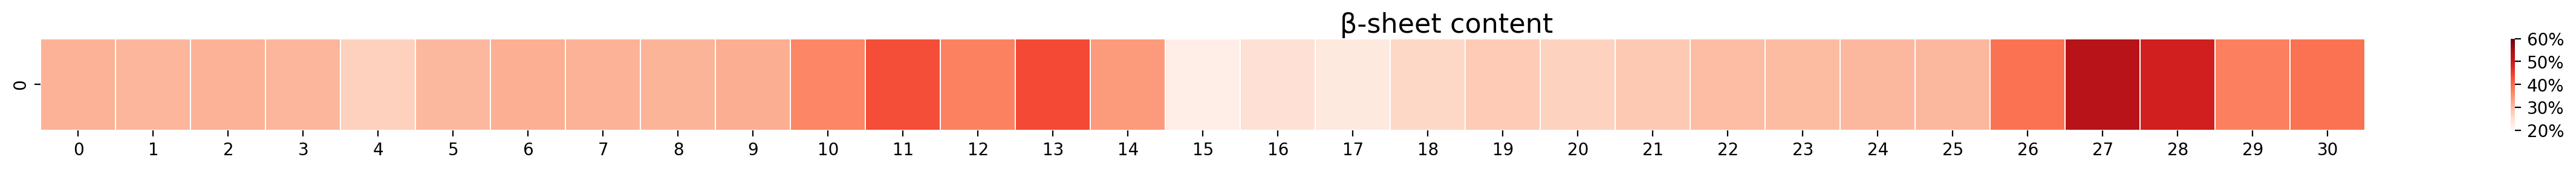

In [ ]:
#heatmap via seaborn with automatically changing intensity axis
import math
plt.figure(figsize = (num_in_x,num_in_y),dpi=200)

#generate mininum and maximum values for colorscale by rounding to the nearest "10", then going down for min and up for max
vminimum = math.floor(min(total_beta_percent)*10)/10
print('vmin', vminimum)
vmaximum = math.ceil(max(total_beta_percent)*10)/10
print('vmax',vmaximum)
hmtitletext  = ('\u03B2-sheet content' + "\n")
ax_example = sns.heatmap(break_total_beta_percent[0:(num_in_x)], cmap="Reds",vmin=vminimum, vmax=vmaximum, linewidths=.05)
plt.suptitle(hmtitletext , fontsize=16,y=1.1, va='top')
fig.subplots_adjust(hspace=.2, wspace=.2)

# ax_example.invert_yaxis()
cbar = ax_example.collections[0].colorbar
l = np.arange(vminimum,vmaximum+.1,0.1)
print('l', l)
l1 = ["%.1f" % member for member in l*100]
print('l1', l1)
cbar.set_ticks(l)
l2 =  ["%.0f" % member for member in l*100]
l3 =list(map("{}%".format,l2))
cbar.set_ticklabels(l3)

#save heatmap into file
fullfigname = (savefolderpath+'/'+'HeatmapFitScalebar.png')
plt.savefig(fullfigname)

In [ ]:
#heatmap via seaborn, beta sheet plotted between user generated endpoints:

# Input for min and max beta sheet for heatmap scale
# Modified from https://www.geeksforgeeks.org/python-tkinter-entry-widget/
# Returns bsMin and bsMax globally
root=tk.Tk()
 
# setting the windows size
root.geometry("450x100")
root.eval('tk::PlaceWindow . center')
#root.lift()

# declaring numerical variables for storing x and y values
bsMin=tk.IntVar()
bsMax=tk.IntVar()
bsStep=tk.IntVar()

# defining a function that will get x and y values and close the window
def submit():
    global user_message_entry, bsMinNum,bsMaxNum, bsStepNum
    # t = Toplevel(root)
    bsMinNum=int(bsMin.get())
    bsMaxNum=int(bsMax.get())
    bsStepNum=int(bsStep.get())
    print("Total number of spectra: " + str(bsMinNum*bsMaxNum))
    time.sleep(0.5)
    root.destroy()
    
# creating a label for input of min % using widget Label
bsMin_label = tk.Label(root, text = 'Minimum % for beta-sheet: ', font=('calibre',10, 'bold'))
  
# creating a entry for input of min % using widget Entry
bsMin_entry = tk.Entry(root,textvariable = bsMin, font=('calibre',10,'normal'))
  
# creating a label for input of max % using widget Label
bsMax_label = tk.Label(root, text = 'Maximum % for beta-sheet: ', font = ('calibre',10,'bold'))
  
# creating a entry for input of max % using widget Entry
bsMax_entry=tk.Entry(root, textvariable = bsMax, font = ('calibre',10,'normal'))
  
# creating a label for input of max % using widget Label
bsStep_label = tk.Label(root, text = 'Step size in % of beta-sheet for scale bar: ', font = ('calibre',10,'bold'))
  
# creating a entry for input of max % using widget Entry
bsStep_entry=tk.Entry(root, textvariable = bsStep, font = ('calibre',10,'normal'))

# creating a label so user knows input of % should be % using widget Label
bsStepPercent_label = tk.Label(root, text = '%', font = ('calibre',10,'bold'))

# creating a button using the widget button that will call the submit function
sub_btn=tk.Button(root,text = 'Submit', command=lambda: submit())
  
# placing the label and entry in the required position using grid method
bsMin_label.grid(row=0,column=0)
bsMin_entry.grid(row=0,column=1)
bsMax_label.grid(row=1,column=0)
bsMax_entry.grid(row=1,column=1)
bsStep_label.grid(row=2,column=0)
bsStep_entry.grid(row=2,column=1)
bsStepPercent_label.grid(row=2,column=2)
sub_btn.grid(row=3,column=1)

# performing an infinite loop for the window to display
root.mainloop()

plt.figure(figsize = (num_in_x,num_in_y),dpi=200)

hmtitletext  = ('\u03B2-sheet content' + "\n")
ax_example = sns.heatmap(break_total_beta_percent[0:(num_in_x)], cmap="Reds",vmin=bsMinNum/100, vmax=bsMaxNum/100, linewidths=.05)
plt.suptitle(hmtitletext , fontsize=16,y=1.1, va='top')
fig.subplots_adjust(hspace=.2, wspace=.2)
# ax_example.invert_yaxis()
cbar = ax_example.collections[0].colorbar

l = np.arange(bsMinNum/100,bsMaxNum/100+.1,bsStepNum/100)
cbar.set_ticks(l)
print('l', l)
l1 = ["%.1f" % member for member in l*100]
print('l1', l1)

l2 =  ["%.0f" % member for member in l*100]
l3 =list(map("{}%".format,l2))
print('l3', l3)
cbar.set_ticklabels(l3)

#save heatmap into file
fullfigname = (savefolderpath+'/'+'HeatmapUserInputScalebar.png')
plt.savefig(fullfigname)

#Statistics

In [ ]:
#crreate Mean, 
total_beta_sheet_df['5min.*']


KeyError: '5min.*'

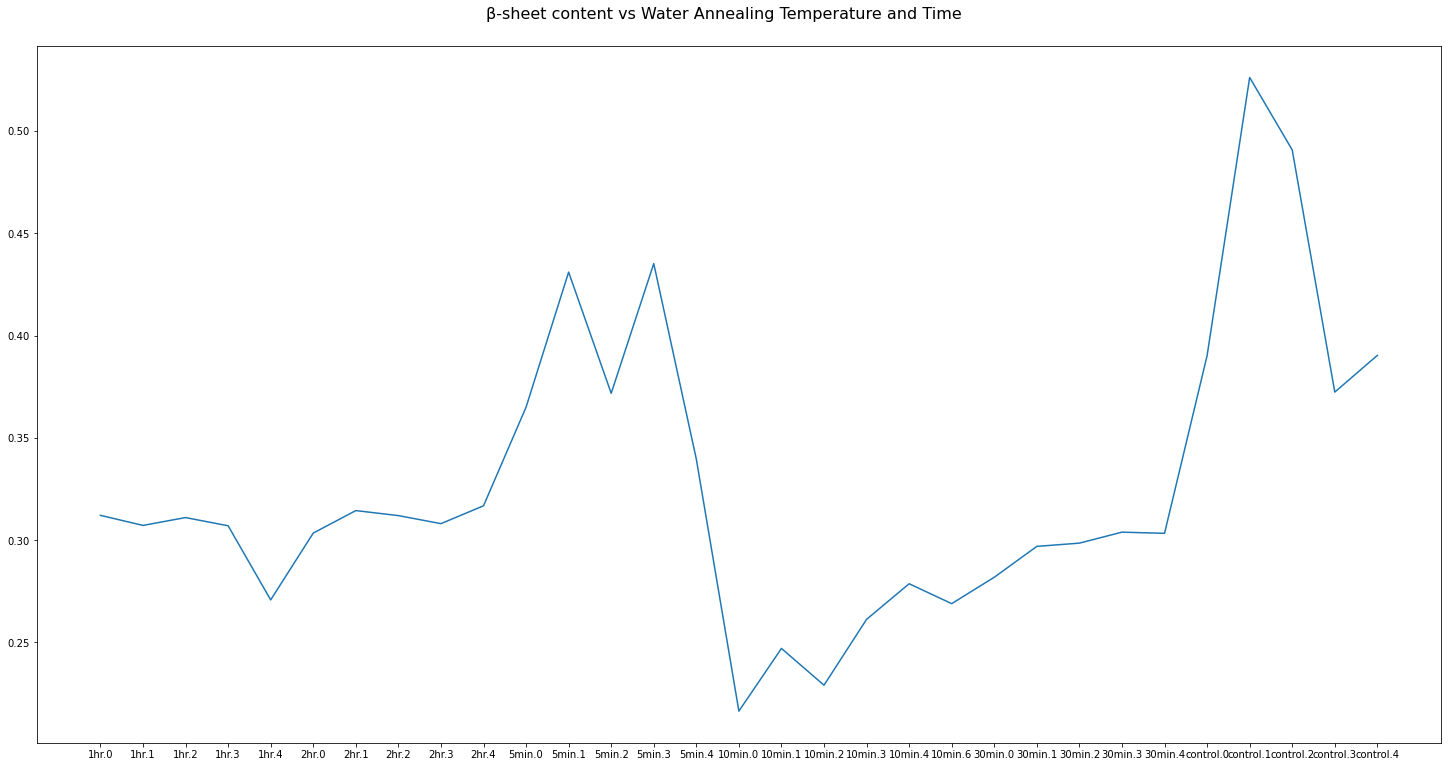

In [ ]:

#plot beta sheet concentration vs time
fig, ax = plt.subplots(figsize=(20, 10),layout = 'constrained') 

titletext  = ('\u03B2-sheet content vs Water Annealing Temperature and Time')
fig.suptitle(titletext, fontsize=16,y=1.05, va='top')
ax.plot(total_beta_sheet_df.columns,total_beta_percent,label='45C')

plt.show()